# Simulation demo

In [1]:
import numpy as np
from decimal import Decimal

In [2]:
from latticemc.definitions import Lattice, LatticeState, OrderParametersHistory, DefiningParameters
from latticemc.lattice_tools import initialize_partially_ordered
from latticemc.random_quaternion import random_quaternion
from latticemc.updaters import AcceptanceRateWiggleRateAdjustor, RandomWiggleRateAdjustor
from latticemc.parallel import SimulationRunner, ProgressBarMode

## Set up simulation

We'll create a simulation with multiple temperatures.
With the new immediate logging approach, data is logged as soon as it's received from simulation processes.

In [3]:
# Setup simulation with multiple temperatures
temperatures = np.arange(0.3, 1.7, 0.1)  # Fewer temps for faster demo
states = [LatticeState(parameters=DefiningParameters(temperature=round(Decimal(t), 2), lam=round(Decimal(0.3),2), tau=1),
                       lattice=Lattice(10, 10, 10))  # Smaller lattice for faster demo
          for t in temperatures]
for state in states:
    initialize_partially_ordered(state.lattice, x=random_quaternion(1.0))

order_parameters_history = {state.parameters: OrderParametersHistory(state.lattice.size) for state in states}

In [4]:
# Setup updaters
per_state_updaters = [
    AcceptanceRateWiggleRateAdjustor(how_often=20, since_when=20),
    RandomWiggleRateAdjustor(scale=0.001, how_often=100, since_when=100, until=1000),
    RandomWiggleRateAdjustor(scale=1.0, reset_value=1.0, how_often=500, since_when=500, until=1000)
]


In [5]:
[state.parameters for state in states]

[DefiningParameters(temperature=Decimal('0.30'), tau=1, lam=Decimal('0.30')),
 DefiningParameters(temperature=Decimal('0.40'), tau=1, lam=Decimal('0.30')),
 DefiningParameters(temperature=Decimal('0.50'), tau=1, lam=Decimal('0.30')),
 DefiningParameters(temperature=Decimal('0.60'), tau=1, lam=Decimal('0.30')),
 DefiningParameters(temperature=Decimal('0.70'), tau=1, lam=Decimal('0.30')),
 DefiningParameters(temperature=Decimal('0.80'), tau=1, lam=Decimal('0.30')),
 DefiningParameters(temperature=Decimal('0.90'), tau=1, lam=Decimal('0.30')),
 DefiningParameters(temperature=Decimal('1.00'), tau=1, lam=Decimal('0.30')),
 DefiningParameters(temperature=Decimal('1.10'), tau=1, lam=Decimal('0.30')),
 DefiningParameters(temperature=Decimal('1.20'), tau=1, lam=Decimal('0.30')),
 DefiningParameters(temperature=Decimal('1.30'), tau=1, lam=Decimal('0.30')),
 DefiningParameters(temperature=Decimal('1.40'), tau=1, lam=Decimal('0.30')),
 DefiningParameters(temperature=Decimal('1.50'), tau=1, lam=Deci

## Thermalization

In [6]:
# Setup simulation runner for thermalization
order_parameters_history_thermalization = {state.parameters: OrderParametersHistory(state.lattice.size) for state in states}
runner_thermalization = SimulationRunner(initial_states=states,
                          order_parameters_history=order_parameters_history_thermalization,
                          cycles=2000,
                          per_state_updaters=per_state_updaters,
                          progress_bar_mode=ProgressBarMode.NOTEBOOK,
                          report_order_parameters_every=500,
                          report_state_every=500,
                          parallel_tempering_interval=10,  # More frequent PT swaps during thermalization
                          save_interval=500,
                          working_folder='./simulation_demo/thermalization',
                          plot_recent_points=500,
                          auto_recover=True)
runner_thermalization.start()


Overall Progress:   0%|          | 0/28000 [00:00<?, ?steps/s]

Sim 0 (T=0.300):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 1 (T=0.400):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 2 (T=0.500):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 3 (T=0.600):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 4 (T=0.700):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 5 (T=0.800):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 6 (T=0.900):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 7 (T=1.000):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 8 (T=1.100):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 9 (T=1.200):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 10 (T=1.300):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 11 (T=1.400):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 12 (T=1.500):   0%|          | 0/2000 [00:00<?, ?steps/s]

Sim 13 (T=1.600):   0%|          | 0/2000 [00:00<?, ?steps/s]

In [8]:

runner_thermalization.finished_gracefully()

All simulation processes finished gracefully


True

In [7]:
runner_thermalization.stop()

## Configure main simulation

In [ ]:
# Setup updaters
per_state_updaters = [
    AcceptanceRateWiggleRateAdjustor(how_often=20, since_when=20),
]

runner = SimulationRunner(states,
                         order_parameters_history,
                         cycles=5000,
                         report_order_parameters_every=50,
                         report_state_every=50,
                         per_state_updaters=per_state_updaters,
                         parallel_tempering_interval=50,
                         save_interval=100,
                         plot_recent_points=1000,
                         working_folder='./simulation_demo',  # TensorBoard logs go to ./simulation_demo/tensorboard
                         progress_bar_mode=ProgressBarMode.NOTEBOOK)

## Progress Bars

The simulation now includes progress bars to track the simulation progress:
- **Main progress bar**: Shows overall simulation progress across all temperatures
- **Per-simulation progress bars**: Individual progress for each temperature simulation

These progress bars work seamlessly with TensorBoard logging and provide real-time feedback on simulation status.

In [ ]:
# Start the simulation
runner.start()

Overall Progress:   0%|          | 0/70000 [00:00<?, ?steps/s]

Sim 0 (T=0.300):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 1 (T=0.400):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 2 (T=0.500):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 3 (T=0.600):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 4 (T=0.700):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 5 (T=0.800):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 6 (T=0.900):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 7 (T=1.000):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 8 (T=1.100):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 9 (T=1.200):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 10 (T=1.300):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 11 (T=1.400):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 12 (T=1.500):   0%|          | 0/5000 [00:00<?, ?steps/s]

Sim 13 (T=1.600):   0%|          | 0/5000 [00:00<?, ?steps/s]

All simulation processes finished gracefully


## Launch TensorBoard

While the simulation is running, you can launch TensorBoard in a new terminal to visualize the progress:

```bash
tensorboard --logdir=./tensorboard_demo/tensorboard
```

This will start a local server, typically at http://localhost:6006, where you can view the visualizations.

### What you'll see in TensorBoard:

1. **Order Parameters**: Real-time plots of energy, q0, q2, w, p, d322 for each temperature
2. **Acceptance Rates**: Live monitoring of orientation and parity move acceptance rates
3. **Lattice Energy**: Energy values from lattice averages updated as states are received

**Note**: Fluctuation analysis can be performed post-simulation using the saved CSV data, which includes both averages and fluctuations calculated from the complete order parameter history.

In [ ]:
# If you want to stop the simulation early
runner.stop()

In [ ]:
# Check if the simulation is still running
runner.alive()

In [12]:
# When done, check if it finished properly
runner.finished_gracefully()

All simulation processes finished gracefully


True

# Analyzing Results with Pandas

After the simulation completes, you can analyze the comprehensive data that was saved in CSV and XZ formats. The simulation creates several types of data files for analysis.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load the final parameter summary data (contains decorrelated averages over full history)
data_path = Path('./simulation_demo/data/')

# Load the comprehensive parameter summary table
# This contains one row per parameter set with all averaged quantities
df_summary = pd.read_pickle(data_path / 'parameter_summary_final.xz')
df_summary['parameters_temperature'] = df_summary['parameters_temperature'].apply(float)
df_summary['parameters_lam'] = df_summary['parameters_lam'].apply(float)
df_summary['parameters_tau'] = df_summary['parameters_tau'].apply(float)
df_summary


,parameters_temperature,parameters_lam,parameters_tau,lattice_X,lattice_Y,lattice_Z,avg_energy,avg_q0,avg_q2,avg_w,avg_p,avg_d322,fl_energy,fl_q0,fl_q2,fl_w,fl_p,fl_d322
0,0.3,0.3,1.0,10,10,10,-5.925828,0.971716,0.345895,0.518300,0.840000,0.931604,1.583115,0.003482,0.001255,0.005235,0.002722,0.016271
1,0.4,0.3,1.0,10,10,10,-5.733732,0.961254,0.324843,0.558949,0.792700,0.908629,3.156453,0.005733,0.005420,0.033675,0.010542,0.023550
2,0.5,0.3,1.0,10,10,10,-5.551007,0.948594,0.327779,0.541824,0.804856,0.881880,5.968554,0.016136,0.052952,0.288180,0.365244,0.051481
3,0.6,0.3,1.0,10,10,10,-5.334841,0.935879,0.312642,0.567335,0.773100,0.853316,9.383731,0.021094,0.161769,0.880766,1.135019,0.087304
4,0.7,0.3,1.0,10,10,10,-4.968565,0.918469,0.243050,0.710914,0.599740,0.813672,18.261333,0.038405,0.802965,2.533062,4.771130,0.184746
5,0.8,0.3,1.0,10,10,10,-4.593594,0.898075,0.145974,0.869190,0.346924,0.768901,30.367802,0.111625,3.518708,7.330697,21.325670,0.535443
6,0.9,0.3,1.0,10,10,10,-4.196023,0.867767,0.122280,0.895581,0.270692,0.707301,65.092361,0.322057,3.369048,6.094962,18.138828,1.927838
7,1.0,0.3,1.0,10,10,10,-3.777535,0.831194,0.076701,0.956176,0.154752,0.644185,28.193905,0.205458,0.975045,1.895750,3.956381,1.089395
8,1.1,0.3,1.0,10,10,10,-3.084264,0.735465,0.095534,0.883345,0.122456,0.510753,424.902802,15.016860,3.915355,27.786018,7.202045,16.699648
9,1.2,0.3,1.0,10,10,10,-2.133811,0.585950,0.074955,0.841217,0.056472,0.325917,404.763580,36.729618,3.650639,72.507271,1.876511,17.734192


In [20]:
# Display basic info about the data
print(f"Data shape: {df_summary.shape}")
print(f"Temperature range: {df_summary['parameters_temperature'].min():.2f} - {df_summary['parameters_temperature'].max():.2f}")
print("\nAvailable columns:")
print([col for col in df_summary.columns if col.startswith(('avg_', 'fl_'))])

Data shape: (14, 18)
Temperature range: 0.30 - 1.60

Available columns:
['avg_energy', 'avg_q0', 'avg_q2', 'avg_w', 'avg_p', 'avg_d322', 'fl_energy', 'fl_q0', 'fl_q2', 'fl_w', 'fl_p', 'fl_d322']


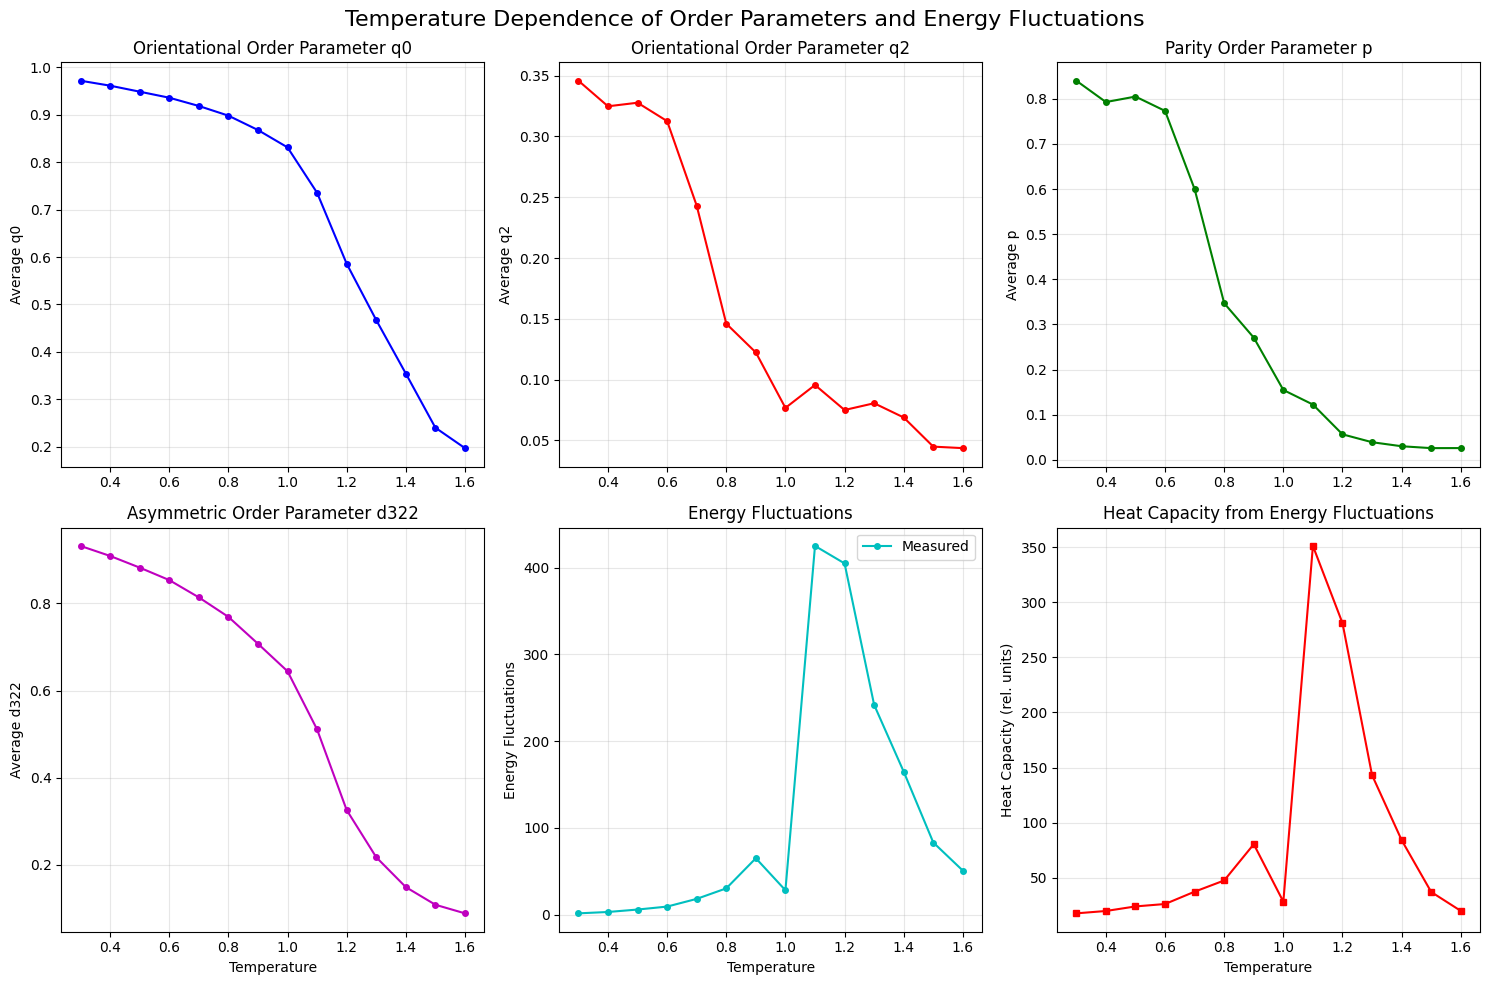

In [23]:
%matplotlib inline
# Create comprehensive temperature plots showing order parameters and energy fluctuations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Temperature Dependence of Order Parameters and Energy Fluctuations', fontsize=16)

# Sort data by temperature for smooth curves
df_sorted = df_summary.sort_values('parameters_temperature')
temps = df_sorted['parameters_temperature']

# Plot order parameters: q0, q2, p, d322
axes[0, 0].plot(temps, df_sorted['avg_q0'], 'bo-', label='q0', markersize=4)
axes[0, 0].set_ylabel('Average q0')
axes[0, 0].set_title('Orientational Order Parameter q0')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(temps, df_sorted['avg_q2'], 'ro-', label='q2', markersize=4)
axes[0, 1].set_ylabel('Average q2')
axes[0, 1].set_title('Orientational Order Parameter q2')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(temps, df_sorted['avg_p'], 'go-', label='p', markersize=4)
axes[0, 2].set_ylabel('Average p')
axes[0, 2].set_title('Parity Order Parameter p')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].plot(temps, df_sorted['avg_d322'], 'mo-', label='d322', markersize=4)
axes[1, 0].set_ylabel('Average d322')
axes[1, 0].set_xlabel('Temperature')
axes[1, 0].set_title('Asymmetric Order Parameter d322')
axes[1, 0].grid(True, alpha=0.3)

# Plot energy fluctuations (both measured during simulation and calculated from history)
axes[1, 1].plot(temps, df_sorted['fl_energy'], 'co-', label='Measured', markersize=4)
axes[1, 1].set_ylabel('Energy Fluctuations')
axes[1, 1].set_xlabel('Temperature')
axes[1, 1].set_title('Energy Fluctuations')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Heat capacity (proportional to energy fluctuations / T^2)
heat_capacity = df_sorted['fl_energy'] / (df_sorted['parameters_temperature']**2)
axes[1, 2].plot(temps, heat_capacity, 'rs-', label='C ∝ ⟨ΔE²⟩/T²', markersize=4)
axes[1, 2].set_ylabel('Heat Capacity (rel. units)')
axes[1, 2].set_xlabel('Temperature')
axes[1, 2].set_title('Heat Capacity from Energy Fluctuations')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()